In [1]:
import numpy as np
import scipy.optimize as opt
from sklearn.utils import resample
import matplotlib.pyplot as plt
import datetime as dt
from dateutil.relativedelta import relativedelta
import pyrenko
import pandas as pd
import talib

#ignoring warnings
import warnings
warnings.simplefilter('ignore')

#importing neccesary modules
import sys
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
from dateutil.parser import parse
import time
from datetime import datetime, timezone
from dateutil import parser
import oandapyV20.endpoints.instruments as instruments
import configparser
import json
from oandapyV20 import API
import oandapyV20.endpoints.positions as positions
import oandapyV20.endpoints.trades as trades
from oandapyV20.endpoints.pricing import PricingStream
import oandapyV20.endpoints.orders as orders
import oandapyV20.endpoints.accounts as accounts
from oandapyV20.contrib.factories import InstrumentsCandlesFactory
from oandapyV20.contrib.requests import MarketOrderRequest, TrailingStopLossDetails
from oandapyV20.exceptions import V20Error, StreamTerminated
import sqlite3
from collections import OrderedDict, ChainMap

In [2]:
#https://oanda-api-v20.readthedocs.io/en/latest/index.html
config = configparser.ConfigParser()
config.read('oanda.cfg')

client = API(access_token=config['oanda']['access_token'])

In [3]:
def get_data(_from, _to, granularity, instrument, save_csv=False):
    """
        Collect historical data for training
        _from="2018-01-01 00:00"    date and time to start collecting candles
        _to=""                      date and time to end the collection of candles, if "", then end will be now.
        save_csv if True will save csv file in current folder
    """
    if _to == "":
        _to = datetime.strptime(datetime.now().isoformat()[0:19] + "Z", '%Y-%m-%dT%H:%M:%SZ').strftime('%Y-%m-%dT%H:%M:%SZ')
    else:
        _to = datetime.strptime(parser.parse(_to).isoformat() + "Z", '%Y-%m-%dT%H:%M:%SZ').strftime('%Y-%m-%dT%H:%M:%SZ')
    params = {
    "granularity": granularity,
    "from": datetime.strptime(parser.parse(_from).isoformat() + "Z", '%Y-%m-%dT%H:%M:%SZ').strftime('%Y-%m-%dT%H:%M:%SZ'),
    "to": _to
    }
    
    df = pd.DataFrame(columns=["Date", 'Open', 'High', 'Low', 'Close', "Volume"])
    for r in InstrumentsCandlesFactory(instrument=instrument, params=params):
        rv = client.request(r)

        results = [{"Date":candle['time'][0:19], "Open":float(candle['mid']['o']),
                    "High":float(candle['mid']['h']), "Low":float(candle['mid']['l']),
                   "Close":float(candle['mid']['c']), "Volume": float(candle['volume'])
                   } for candle in r.response.get('candles')]
        df = df.append(pd.DataFrame(results), ignore_index=True)
    
    df.set_index("Date", inplace=True)
    if save_csv:
        df.to_csv(instrument + "_" + granularity + ".csv")
    return df

In [4]:
start = "2021-07-09 00:00"    #date and time to start collecting candles
end = ""    #date and time to end the collection of candles, if "", then end will be now.
granularity = "S30"
instrument = "JP225_USD"


In [5]:
df = get_data(_from=start, _to=end, granularity=granularity, instrument=instrument, save_csv=False)
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist() 
df.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2021-07-12T00:52:00,28493.5,28500.9,28491.0,28500.9,16.0
2021-07-12T00:52:30,28500.9,28510.9,28497.2,28510.9,16.0
2021-07-12T00:53:00,28513.4,28515.9,28513.4,28515.9,4.0
2021-07-12T00:53:30,28515.9,28515.9,28507.2,28512.2,16.0
2021-07-12T00:54:00,28511.0,28520.9,28511.0,28519.8,34.0


### Example 2. Renko chart using history data and auto-brick-size (ATR approach)

In [6]:

# Get data for last years
data = df

# Get optimal brick size based
optimal_brick = pyrenko.renko().set_brick_size(auto = True, HLC_history = data[["High", "Low", "Close"]])

# Build Renko chart
renko_obj_atr = pyrenko.renko()
print('Set brick size to optimal: ', renko_obj_atr.set_brick_size(auto = False, brick_size = optimal_brick))
renko_obj_atr.build_history(prices = data.Close)
print('Renko bar prices: ', renko_obj_atr.get_renko_prices())
print('Renko bar directions: ', renko_obj_atr.get_renko_directions())
print('Renko bar evaluation: ', renko_obj_atr.evaluate())



Set brick size to optimal:  7.112754459620983
Renko bar prices:  [27672.2, 27679.31275445962, 27686.42550891924, 27693.53826337886, 27700.65101783848, 27707.7637722981, 27714.876526757722, 27721.989281217342, 27729.102035676962, 27736.214790136582, 27743.327544596203, 27750.440299055823, 27757.553053515443, 27764.665807975063, 27771.778562434683, 27778.891316894304, 27786.004071353924, 27793.116825813544, 27800.229580273164, 27807.342334732784, 27814.455089192405, 27821.567843652025, 27828.680598111645, 27835.793352571265, 27842.906107030885, 27850.018861490506, 27857.131615950126, 27842.906107030885, 27835.793352571265, 27828.680598111645, 27821.567843652025, 27814.455089192405, 27807.342334732784, 27800.229580273164, 27793.116825813544, 27807.342334732784, 27814.455089192405, 27821.567843652025, 27807.342334732784, 27821.567843652025, 27828.680598111645, 27814.455089192405, 27807.342334732784, 27800.229580273164, 27793.116825813544, 27786.004071353924, 27800.229580273164, 27807.34233

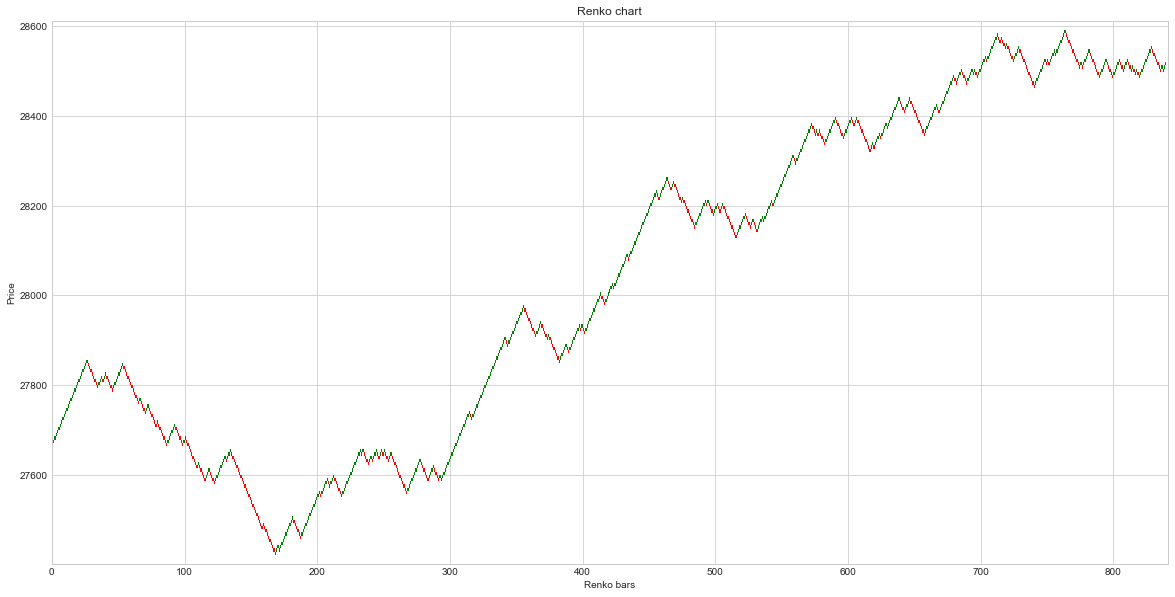

In [7]:
if len(renko_obj_atr.get_renko_prices()) > 1:
    renko_obj_atr.plot_renko()

In [8]:
# Function for optimization
def evaluate_renko(brick, history, column_name):
    renko_obj = pyrenko.renko()
    renko_obj.set_brick_size(brick_size = brick, auto = False)
    renko_obj.build_history(prices = history)
    return renko_obj.evaluate()[column_name]

# Get ATR values (it needs to get boundaries)
# Drop NaNs
atr = talib.ATR(high = np.double(data.High),
                low = np.double(data.Low),
                close = np.double(data.Close),
                timeperiod = 14)
atr = atr[np.isnan(atr) == False]

# Get optimal brick size as maximum of score function by Brent's (or similar) method
# First and Last ATR values are used as the boundaries
optimal_brick_sfo = opt.fminbound(lambda x: -evaluate_renko(brick = x, 
                                                            history = data.Close, column_name = 'score'), 
                                  np.min(atr), np.max(atr), disp=0)
# Build Renko chart
renko_obj_sfo = pyrenko.renko()
print('Set brick size to optimal: ', renko_obj_sfo.set_brick_size(auto = False, brick_size = optimal_brick_sfo))
renko_obj_sfo.build_history(prices = data.Close)
print('Renko bar prices: ', renko_obj_sfo.get_renko_prices())
print('Renko bar directions: ', renko_obj_sfo.get_renko_directions())
print('Renko bar evaluation: ', renko_obj_sfo.evaluate())


Set brick size to optimal:  39.61708496747376
Renko bar prices:  [27672.2, 27711.817084967475, 27751.43416993495, 27791.051254902424, 27830.6683398699, 27751.43416993495, 27711.817084967475, 27672.2, 27632.582915032526, 27592.96583006505, 27553.348745097577, 27513.731660130103, 27474.114575162628, 27434.497490195154, 27513.731660130103, 27553.348745097577, 27592.96583006505, 27632.582915032526, 27672.2, 27711.817084967475, 27751.43416993495, 27791.051254902424, 27830.6683398699, 27870.285424837373, 27909.902509804848, 27949.519594772322, 27870.285424837373, 27949.519594772322, 27989.136679739797, 28028.75376470727, 28068.370849674746, 28107.98793464222, 28147.605019609695, 28187.22210457717, 28226.839189544644, 28147.605019609695, 28226.839189544644, 28266.45627451212, 28306.073359479593, 28345.690444447067, 28385.307529414542, 28424.924614382016, 28464.54169934949, 28504.158784316965, 28543.77586928444, 28583.392954251914, 28504.158784316965, 28464.54169934949, 28543.77586928444, 2858

Score value is not the same. This approach has greater score value than ATR.

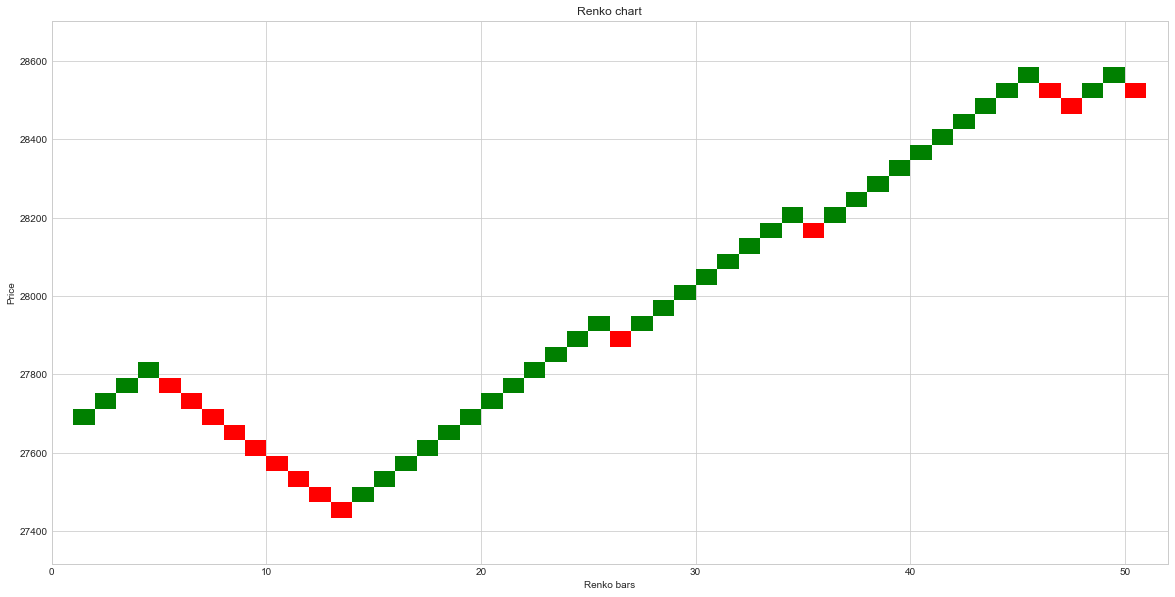

In [9]:
if len(renko_obj_sfo.get_renko_prices()) > 1:
    renko_obj_sfo.plot_renko()

In [10]:
def get_candles(count, granularity, price='B'):
    params={"count": count, "granularity": granularity, 'price': price}
    r = instruments.InstrumentsCandles(instrument="JP225_USD",params=params)
    data = client.request(r)
    
    if price == 'B':
        p = 'bid'
    elif price == 'A':
        p = 'ask'
    results= [{"Date":x['time'],"Open":float(x[p]['o']),"High":float(x[p]['h']),
               "Low":float(x[p]['l']), "Close":float(x[p]['c']), "Volume": float(x['volume'])
              } for x in data['candles'] ] #if x["complete"]
    df = pd.DataFrame(results).set_index('Date')
    df.index = pd.DatetimeIndex(df.index)
    
    return df[["Open", "High", "Low", "Close", "Volume"]]
            


In [11]:
# hier ist ein Lösungsansatz für mein Problem.
# df3 wird außerhalb vom Loop gemacht. Dann wird df2 im Loop abgerufen
# und angehängt. So müsste es eigentlich passen ..... 
# Mal schauen Morgen. 

# Gut jetzt zeige ich auch noch das DataFrame df3 mit Print Modus - damit sehe ich morgen was genau los ist. 

from time import sleep

df3 = pd.DataFrame()


while True:
    df2 = get_candles(count=1, granularity='S30')
    df2.index.name = "Date"
    

    


    sleep(5)
    

    df3 = df3.append(df2)
    

    data = df3

    print(df3)

    # Build Renko chart with the best brick size from Close data :-) 
    renko_obj_atr = pyrenko.renko()
    print('Set brick size to optimal: ', renko_obj_atr.set_brick_size(auto = False, brick_size = optimal_brick_sfo))
    renko_obj_atr.build_history(prices = data.Close)
    print('Renko bar prices: ', renko_obj_atr.get_renko_prices())
    print('Renko bar directions: ', renko_obj_atr.get_renko_directions())
    print('Renko bar evaluation: ', renko_obj_atr.evaluate())
    
    
    
    if len(renko_obj_atr.get_renko_prices()) > 1:
        renko_obj_atr.plot_renko()

                              Open     High      Low    Close  Volume
Date                                                                 
2021-07-12 00:54:30+00:00  28515.0  28515.6  28514.5  28514.5     4.0
Set brick size to optimal:  39.61708496747376
Renko bar prices:  [28514.5]
Renko bar directions:  [0]
Renko bar evaluation:  {'balance': 0, 'sign_changes:': 1, 'price_ratio': 1.0, 'score': 0.0}
                              Open     High      Low    Close  Volume
Date                                                                 
2021-07-12 00:54:30+00:00  28515.0  28515.6  28514.5  28514.5     4.0
2021-07-12 00:54:30+00:00  28515.0  28521.9  28514.5  28521.9     6.0
Set brick size to optimal:  39.61708496747376
Renko bar prices:  [28514.5]
Renko bar directions:  [0]
Renko bar evaluation:  {'balance': 0, 'sign_changes:': 1, 'price_ratio': 2.0, 'score': 0.0}
                              Open     High      Low    Close  Volume
Date                                                

KeyboardInterrupt: 

In [ ]:
def create_order(units, instrument, sld):
    #sld = trailing stop loss distance
    
    dfOrder = pd.DataFrame()
    order = orders.OrderCreate(accountID=config['oanda']['account_id'], 
                               data=MarketOrderRequest(instrument=instrument, units=units, 
                                                       trailingStopLossOnFill=TrailingStopLossDetails(distance=sld).data).data)
    response = client.request(order)
    
    print(response["orderFillTransaction"]['time'], "--",
          "Instrument = ", response['orderFillTransaction']['instrument'], "--",
          "Price = ", float(response['orderFillTransaction']['price']), "--",
          "PL = ", float(response['orderFillTransaction']['pl']))

In [ ]:
# Here I have built in the trading logic to confirm that it is working out
# this would have to be more .... you know ... but as a quick demonstration it shows how it would have
# to be - missing is to check open positions for the first entry - and also how to close when direction 
# is changing 

#if (renko_obj_sfo.get_renko_directions()[-1]) == -1:
       # create_order(units=-1000, instrument="JP225_USD", sld = 1)
       # print('SELL')

In [ ]:
#if (renko_obj_sfo.get_renko_directions()[-1]) == 1:
       # create_order(units=1000, instrument="JP225_USD", sld = 1)
       # print('Buy')